# 作業 : (Kaggle)鐵達尼生存預測
***
- 分數以網站評分結果為準, 請同學實際將提交檔(*.csv)上傳試試看  
https://www.kaggle.com/c/titanic/submit

# [作業目標]
- 試著模仿範例寫法, 在鐵達尼生存預測中, 觀察觀查混合泛化 (Blending) 的寫法與效果

# [作業重點]
- 觀察混合泛化的準確度 (In[14]), 是否比單一模型準確度為高 (In[11~13])  
- 除了我們的權重, 同學也可以試著自行調整權重 (注意:權重和=1), 看看有什麼影響
- Hint : 除了權重, 分類預測的調整, 還可以調整什麼地方?

In [74]:
# 做完特徵工程前的所有準備 (與前範例相同)
import pandas as pd
import numpy as np
import copy, time
import warnings
warnings.filterwarnings('ignore')
import xgboost as xgb
from IPython.display import display
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.model_selection import cross_val_score,GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifierfrom sklearn.preprocessing import LabelEncoder

data_path = '../data/titanic/'
df_train = pd.read_csv(data_path + 'titanic_train.csv')
df_test = pd.read_csv(data_path + 'titanic_test.csv')

train_Y = df_train['Survived']
ids = df_test['PassengerId']
df_train = df_train.drop(['PassengerId', 'Survived'] , axis=1)
df_test = df_test.drop(['PassengerId'] , axis=1)
df = pd.concat([df_train,df_test])
df.head()

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [75]:
# 檢查 DataFrame 空缺值的狀態
def na_check(df_data):
    data_na = (df_data.isnull().sum() / len(df_data)) * 100
    data_na = data_na.drop(data_na[data_na == 0].index).sort_values(ascending=False)
    missing_data = pd.DataFrame({'Missing Ratio' :data_na})
    display(missing_data.head(10))
na_check(df)

,Missing Ratio
Cabin,77.463713
Age,20.091673
Embarked,0.152788
Fare,0.076394


In [76]:
# 以下 In[3]~In[10] 只是鐵達尼預測中的一組特徵工程, 並以此組特徵工程跑參數, 若更換其他特徵工程, In[10]的參數需要重新跑
# Sex : 直接轉男 0 女 1
df["Sex"] = df["Sex"].map({"male": 0, "female":1})
# Fare : 用 log 去偏態, 0 則直接取 0
df["Fare"] = df["Fare"].map(lambda i: np.log(i) if i > 0 else 0)
# Age : 缺值用中位數補
df["Age"] = df["Age"].fillna(df['Age'].median())

In [77]:
## 對Cabin count label
cabin_count = df['Cabin'].value_counts()
cabin_map = dict(zip(cabin_count.index,cabin_count.values))
df['Cabin'] = df['Cabin'].replace(cabin_map)
df['Cabin'] = df['Cabin'].fillna(0)
df['Cabin'].head()

0    0.0
1    2.0
2    0.0
3    2.0
4    0.0
Name: Cabin, dtype: float64

In [80]:
embarked_count = df['Embarked'].value_counts().reset_index()
embarked_count.columns = ['embarked','count']
embarked_count['count'] = round(embarked_count['count']/embarked_count['count'].sum(),2)
em_dict = dict(zip(embarked_count['embarked'],embarked_count['count']))

df['Embarked'] = df['Embarked'].replace(em_dict)
df['Embarked'] = df['Embarked'].fillna(df['Embarked'].max())
df['Embarked'].head()

0    0.70
1    0.21
2    0.70
3    0.70
4    0.70
Name: Embarked, dtype: float64

## 對cabin embarked 計數編碼  ,drop其餘類別變數

In [98]:
df2 = df.copy()
df2 = df2.select_dtypes(exclude=['object'])
df2.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
0,3,0,22.0,1,0,1.981001,0.0,0.70
1,1,1,38.0,1,0,4.266662,2.0,0.21
2,3,1,26.0,0,0,2.070022,0.0,0.70
3,1,1,35.0,1,0,3.972177,2.0,0.70
4,3,0,35.0,0,0,2.085672,0.0,0.70


In [99]:
# 將資料最大最小化
df2 = StandardScaler().fit_transform(df2)
# 將前述轉換完畢資料 df , 重新切成 train_X, test_X
train_num = train_Y.shape[0]
train_X = df2[:train_num]
test_X = df2[train_num:]

GBC = GradientBoostingClassifier()
print("GBC : ",cross_val_score(GBC,train_X,train_Y).mean())

RF = RandomForestClassifier()
print("RF : ",cross_val_score(RF,train_X,train_Y).mean())

xgb = XGBClassifier()
print("XGB : ",cross_val_score(xgb,train_X,train_Y).mean())

GBC :  0.8103254769921436
RF :  0.8035914702581369
XGB :  0.8181818181818182


## 加上Title ticket 特徵工程

In [101]:
df2 = df.copy()
df2.head()

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,3,"Braund, Mr. Owen Harris",0,22.0,1,0,A/5 21171,1.981001,0.0,0.70
1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38.0,1,0,PC 17599,4.266662,2.0,0.21
2,3,"Heikkinen, Miss. Laina",1,26.0,0,0,STON/O2. 3101282,2.070022,0.0,0.70
3,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35.0,1,0,113803,3.972177,2.0,0.70
4,3,"Allen, Mr. William Henry",0,35.0,0,0,373450,2.085672,0.0,0.70


In [102]:
# Title 的 特徵工程 : 將各種頭銜按照類型分類, 最後取 One Hot
df2_title = [i.split(",")[1].split(".")[0].strip() for i in df2["Name"]]
df2["Title"] = pd.Series(df2_title)
df2["Title"] = df2["Title"].replace(['Lady', 'the Countess','Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
df2["Title"] = df2["Title"].map({"Master":0, "Miss":1, "Ms" : 1 , "Mme":1, "Mlle":1, "Mrs":1, "Mr":2, "Rare":3})
df2["Title"] = df2["Title"].astype(int)
df2 = pd.get_dummies(df2, columns = ["Title"])

In [103]:
# Ticket : 如果不只是數字-取第一個空白之前的字串(去除'.'與'/'), 如果只是數字-設為'X', 最後再取 One Hot
Ticket = []
for i in list(df2.Ticket):
    if not i.isdigit() :
        Ticket.append(i.replace(".","").replace("/","").strip().split(' ')[0])
    else:
        Ticket.append("X")        
df2["Ticket"] = Ticket
df2 = pd.get_dummies(df, columns = ["Ticket"], prefix="T")
df2.head()

,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,T_110152,...,T_W./C. 14258,T_W./C. 14260,T_W./C. 14263,T_W./C. 14266,T_W./C. 6607,T_W./C. 6608,T_W./C. 6609,T_W.E.P. 5734,T_W/C 14208,T_WE/P 5735
0,3,"Braund, Mr. Owen Harris",0,22.0,1,0,1.981001,0.0,0.70,0,...,0,0,0,0,0,0,0,0,0,0
1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38.0,1,0,4.266662,2.0,0.21,0,...,0,0,0,0,0,0,0,0,0,0
2,3,"Heikkinen, Miss. Laina",1,26.0,0,0,2.070022,0.0,0.70,0,...,0,0,0,0,0,0,0,0,0,0
3,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35.0,1,0,3.972177,2.0,0.70,0,...,0,0,0,0,0,0,0,0,0,0
4,3,"Allen, Mr. William Henry",0,35.0,0,0,2.085672,0.0,0.70,0,...,0,0,0,0,0,0,0,0,0,0


In [104]:
df2 = df2.select_dtypes(exclude=['object'])
# 將資料最大最小化
df2 = StandardScaler().fit_transform(df2)
# 將前述轉換完畢資料 df , 重新切成 train_X, test_X
train_num = train_Y.shape[0]
train_X = df2[:train_num]
test_X = df2[train_num:]

GBC = GradientBoostingClassifier()
print("GBC : ",cross_val_score(GBC,train_X,train_Y).mean())

RF = RandomForestClassifier()
print("RF : ",cross_val_score(RF,train_X,train_Y).mean())

xgb = XGBClassifier()
print("XGB : ",cross_val_score(xgb,train_X,train_Y).mean())


GBC :  0.8170594837261503
RF :  0.8047138047138048
XGB :  0.8181818181818182


## 調整樹的最佳化參數

In [110]:
# 找尋最佳參數的函示
def find_bestparam(alg,X,y):
    n_estimators = [100,150,200]
    max_depth = [3, 5,7,9]
    param_grid = dict(n_estimators=n_estimators, max_depth=max_depth)

    ## 建立搜尋物件，放入模型及參數組合字典 (n_jobs=-1 會使用全部 cpu 平行運算)
    grid_search = GridSearchCV(alg(), param_grid, scoring="neg_mean_squared_error", n_jobs=-1, verbose=1)

    # 開始搜尋最佳參數
    grid_result = grid_search.fit(X, y)

    # 使用最佳參數重新建立模型
    alg_bestparam =  alg(max_depth=grid_result.best_params_['max_depth'],
                                               n_estimators=grid_result.best_params_['n_estimators'])
    
    score = cross_val_score(alg_bestparam,X,y).mean()
    # 印出最佳結果與最佳參數
    print ("Best cross_val_score: %f using %s" % (score, grid_result.best_params_))
    
alg_list = [GradientBoostingClassifier, RandomForestClassifier, XGBClassifier]
for alg in alg_list:
    find_bestparam(alg,train_X,train_Y)

Fitting 3 folds for each of 12 candidates, totalling 36 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  36 out of  36 | elapsed:  1.2min finished


Best cross_val_score: 0.826038 using {'max_depth': 7, 'n_estimators': 150}
Fitting 3 folds for each of 12 candidates, totalling 36 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  36 out of  36 | elapsed:    4.4s finished


Best cross_val_score: 0.760943 using {'max_depth': 9, 'n_estimators': 200}
Fitting 3 folds for each of 12 candidates, totalling 36 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  36 out of  36 | elapsed:  1.7min finished


Best cross_val_score: 0.837262 using {'max_depth': 3, 'n_estimators': 200}


### 上傳結果

In [113]:
# 梯度提升機預測檔 
gdbt = GradientBoostingClassifier(max_depth=7, n_estimators=150)
gdbt.fit(train_X, train_Y)
gdbt_pred = gdbt.predict_proba(test_X)[:,1]
sub = pd.DataFrame({'PassengerId': ids, 'Survived': gdbt_pred})
sub['Survived'] = sub['Survived'].map(lambda x:1 if x>0.5 else 0) 
sub.to_csv('titanic_gdbt.csv', index=False)

In [114]:
# 隨機森林預測檔
rf = RandomForestClassifier(max_depth = 9,n_estimators = 200)
rf.fit(train_X, train_Y)
rf_pred = rf.predict_proba(test_X)[:,1]
sub = pd.DataFrame({'PassengerId': ids, 'Survived': rf_pred})
sub['Survived'] = sub['Survived'].map(lambda x:1 if x>0.5 else 0) 
sub.to_csv('titanic_rf.csv', index=False)

In [115]:
# XGB預測檔
xgb = XGBClassifier(max_depth = 3,n_estimators = 200)
xgb.fit(train_X, train_Y)
xgb_pred = xgb.predict_proba(test_X)[:,1]
sub = pd.DataFrame({'PassengerId': ids, 'Survived': xgb_pred})
sub['Survived'] = sub['Survived'].map(lambda x:1 if x>0.5 else 0) 
sub.to_csv('titanic_xgb.csv', index=False)

In [116]:
# 混合泛化預測檔 
blending_pred = xgb_pred* 0.5 + gdbt_pred*0.45 + rf_pred*0.05
sub = pd.DataFrame({'PassengerId': ids, 'Survived': blending_pred})
sub['Survived'] =  sub['Survived'].map(lambda x: 1 if x>0.5 else 0 )
sub.to_csv('titanic_blending.csv', index=False)

###  score比原先程式碼提升0.05，排名進步5千多名！

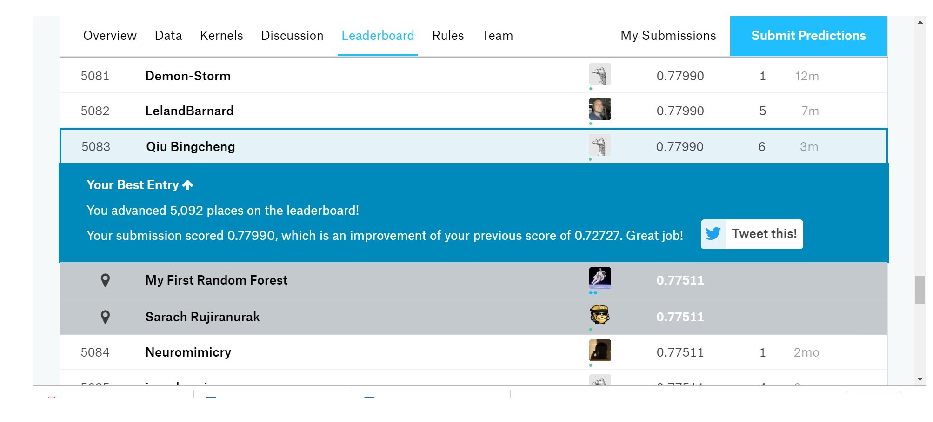

In [118]:
import matplotlib.pyplot as plt # plt 用于显示图片
import matplotlib.image as mpimg # mpimg 用于读取图片

result = mpimg.imread('AAA.jpg') # 读取和代码处于同一目录下的 lena.png
plt.figure(figsize=(16,16))
plt.imshow(result) # 显示图片
plt.axis('off') # 不显示坐标轴
plt.show()

### 以下為原程式碼 

In [ ]:
# Title 的 特徵工程 : 將各種頭銜按照類型分類, 最後取 One Hot
df_title = [i.split(",")[1].split(".")[0].strip() for i in df["Name"]]
df["Title"] = pd.Series(df_title)
df["Title"] = df["Title"].replace(['Lady', 'the Countess','Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
df["Title"] = df["Title"].map({"Master":0, "Miss":1, "Ms" : 1 , "Mme":1, "Mlle":1, "Mrs":1, "Mr":2, "Rare":3})
df["Title"] = df["Title"].astype(int)
df = pd.get_dummies(df, columns = ["Title"])

In [32]:
# 新建:家庭大小 (Fsize)特徵, 並依照大小分別建獨立欄位
df["Fsize"] = df["SibSp"] + df["Parch"] + 1
df['Single'] = df['Fsize'].map(lambda s: 1 if s == 1 else 0)
df['SmallF'] = df['Fsize'].map(lambda s: 1 if  s == 2  else 0)
df['MedF'] = df['Fsize'].map(lambda s: 1 if 3 <= s <= 4 else 0)
df['LargeF'] = df['Fsize'].map(lambda s: 1 if s >= 5 else 0)

In [33]:
# Ticket : 如果不只是數字-取第一個空白之前的字串(去除'.'與'/'), 如果只是數字-設為'X', 最後再取 One Hot
Ticket = []
for i in list(df.Ticket):
    if not i.isdigit() :
        Ticket.append(i.replace(".","").replace("/","").strip().split(' ')[0])
    else:
        Ticket.append("X")        
df["Ticket"] = Ticket
df = pd.get_dummies(df, columns = ["Ticket"], prefix="T")

In [34]:
# Cabib 依照第一碼分類, 再取 One Hot
df["Cabin"] = pd.Series([i[0] if not pd.isnull(i) else 'X' for i in df['Cabin'] ])
df = pd.get_dummies(df, columns = ["Cabin"], prefix="Cabin")

In [35]:
# Embarked, Pclass 取 One Hot
df = pd.get_dummies(df, columns = ["Embarked"], prefix="Em")
df["Pclass"] = df["Pclass"].astype("category")
df = pd.get_dummies(df, columns = ["Pclass"], prefix="Pc")

# 捨棄 Name 欄位
df.drop(labels = ["Name"], axis = 1, inplace = True)

In [36]:
# 確認缺值 與 目前的資料表內容
na_check(df)
df.head()

,Missing Ratio


,Sex,Age,SibSp,Parch,Fare,Title_0,Title_1,Title_2,Title_3,Fsize,...,Cabin_F,Cabin_G,Cabin_T,Cabin_X,Em_C,Em_Q,Em_S,Pc_1,Pc_2,Pc_3
0,0,22.0,1,0,1.981001,0,0,1,0,2,...,0,0,0,1,0,0,1,0,0,1
1,1,38.0,1,0,4.266662,0,1,0,0,2,...,0,0,0,0,1,0,0,1,0,0
2,1,26.0,0,0,2.070022,0,1,0,0,1,...,0,0,0,1,0,0,1,0,0,1
3,1,35.0,1,0,3.972177,0,1,0,0,2,...,0,0,0,0,0,0,1,1,0,0
4,0,35.0,0,0,2.085672,0,0,1,0,1,...,0,0,0,1,0,0,1,0,0,1


In [37]:
# 將資料最大最小化
df = MinMaxScaler().fit_transform(df)

# 將前述轉換完畢資料 df , 重新切成 train_X, test_X
train_num = train_Y.shape[0]
train_X = df[:train_num]
test_X = df[train_num:]
# 使用三種模型 : 邏輯斯迴歸 / 梯度提升機 / 隨機森林, 參數使用 Random Search 尋找
lr = LogisticRegression(tol=0.001, penalty='l2', fit_intercept=True, C=1.0)
gdbt = GradientBoostingClassifier(tol=100, subsample=0.75, n_estimators=250, max_features=20,
                                  max_depth=6, learning_rate=0.03)
rf = RandomForestClassifier(n_estimators=100, min_samples_split=2, min_samples_leaf=1, 
                            max_features='sqrt', max_depth=6, bootstrap=True)

In [38]:
# 線性迴歸預測檔 (結果有部分隨機, 請以 Kaggle 計算的得分為準, 以下模型同理)
lr.fit(train_X, train_Y)
lr_pred = lr.predict_proba(test_X)[:,1]
sub = pd.DataFrame({'PassengerId': ids, 'Survived': lr_pred})
sub['Survived'] = sub['Survived'].map(lambda x:1 if x>0.5 else 0) 
sub.to_csv('titanic_lr.csv', index=False) 

In [39]:
# 梯度提升機預測檔 
gdbt.fit(train_X, train_Y)
gdbt_pred = gdbt.predict_proba(test_X)[:,1]
sub = pd.DataFrame({'PassengerId': ids, 'Survived': gdbt_pred})
sub['Survived'] = sub['Survived'].map(lambda x:1 if x>0.5 else 0) 
sub.to_csv('titanic_gdbt.csv', index=False)

In [40]:
# 隨機森林預測檔
rf.fit(train_X, train_Y)
rf_pred = rf.predict_proba(test_X)[:,1]
sub = pd.DataFrame({'PassengerId': ids, 'Survived': rf_pred})
sub['Survived'] = sub['Survived'].map(lambda x:1 if x>0.5 else 0) 
sub.to_csv('titanic_rf.csv', index=False)

In [46]:
# 隨機森林預測檔
xgb = XGBClassifier()
xgb.fit(train_X, train_Y)
xgb_pred = xgb.predict_proba(test_X)[:,1]
sub = pd.DataFrame({'PassengerId': ids, 'Survived': xgb_pred})
sub['Survived'] = sub['Survived'].map(lambda x:1 if x>0.5 else 0) 
sub.to_csv('titanic_xgb.csv', index=False)

# 作業
* 雖然同樣是混合泛化，分類預測其實與回歸預測有相當多的差異性，
因為鐵達尼預測的結果是 '生存/死亡'，輸出不是 0 就是 1  
因此要用權重混合時，需要以以機率的形式混合，因此我們在作業前幾格當中，先幫各位同學把預測值寫成了機率的形式  
(請同學把下列程式完成，並將結果提交到 Kaggle 網站看看結果)

* 但是光是這樣，分類問題的混合泛化就能比單模預測還要好嗎?  
已經快要期中考了，這裡請同學挑戰看看，還有沒有什麼方法可以改進混合泛化的結果?

In [47]:
# 混合泛化預測檔 
blending_pred = xgb_pred* 0.7 + gdbt_pred*0.25 + rf_pred*0.05
sub = pd.DataFrame({'PassengerId': ids, 'Survived': blending_pred})
sub['Survived'] =  sub['Survived'].map(lambda x: 1 if x>0.5 else 0 )
sub.to_csv('titanic_blending.csv', index=False)